In [1]:
suppressWarnings({
library(lme4)
library(grf)
library(stats)
library(MASS)
library(sandwich)
library(lmtest)
library(dplyr)
library(haven)
library(randomForest)
library(ggplot2)
library(ROCR)
    })

Loading required package: Matrix

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin




In [13]:
# original data 
df <- read_dta("../data/Data_BoganFernandezAER.dta")

# for convenience, drop '_'
colnames(df) <-sub("_", "", colnames(df))

In [14]:
df1 <- df %>% filter(year == 1999) #1698

[1] 11763

In [15]:
n = nrow(df1) #1698
set.seed(10)

#1. dummylist

### control and dummy
controls <- c('specialneeds2', 'specialneeds4', 'grad', 'onechild', 'twochild', 'threechild', 'fourormorechild', 'conditions', 'healthins', 'married', 'divorce', 'young', 'AGEOFHEAD', 'EDUCHD', 'black', 'female', 'own1', 'unemphd', 'manager', 'finance', 'lninc', 'IMPIRA2', 'benefitpension', 'contributionpension', 'WTRINHERITANCE', 'regionMW', 'regionW', 'regionNE')

### select all dummies
dummy.list <- c(names(df1%>%select_if(~ all(. %in% 0:1))))
ctrl.dummy <- dummy.list[dummy.list %in% controls]

### remove variables of the number of children
num.child <- c('onechild','twochild','threechild','fourormorechild')

ctrl.dummy <- ctrl.dummy[! ctrl.dummy %in% num.child]
#ctrl.dummy

# 2. simulation df with dummies

## generate df for controls
df.sim.dum <- data.frame(n)
sim.dum <- c()
for (val in ctrl.dummy){
    nam <- paste("prob",val, sep = "")
    assign(nam, paste0(prop.table(table(df[val])))[[2]])
    nam <- as.double(get(nam),digits = 5)
    
    nam2 <- paste0(val, "_sim")
    assign(nam2, rbinom(n,1,nam))
    
    dum.col<- data.frame(nam2 = c(get(nam2))) # convert it to dataframe
    df.sim.dum <- cbind(df.sim.dum, dum.col) # append a new col of dummy to existing df
    
    sim.dum <- append(sim.dum, nam2) #save variable name for col names
}

df.sim.dum[1] <- NULL #drop the first column (=n)
colnames(df.sim.dum) <- sim.dum # set col names

# the number of child

#count probability of each number of children in original data (= (sum of col)/(nrow(df1)) )
#make categorial variable according to the probability
#use model.matrix of the categorial var

prob1<- prop.table(table(df1['onechild']))[[2]]
prob2<- prop.table(table(df1['twochild']))[[2]]
prob3<- prop.table(table(df1['threechild']))[[2]]
prob4<- prop.table(table(df1['fourormorechild']))[[2]]

#prob0 <- 1- sum(prob1,prob2,prob3,prob4)

df.sim.dum$numchild_sim <- sample(c(0:3),size = n,prob = c(prob1, prob2, prob3, prob4),replace = TRUE)

numchild_exp = model.matrix(~ factor(df.sim.dum$numchild_sim) + 0) 
colnames(numchild_exp)[1]<-"onechild_sim"
colnames(numchild_exp)[2]<-"twochild_sim"
colnames(numchild_exp)[3]<-"threechild_sim"
colnames(numchild_exp)[4]<-"fourormorechild_sim"

df.sim.dum$numchild_sim<-NULL
df.sim.dum <- cbind(df.sim.dum,numchild_exp)


### apply as.factor for all dummy columns 
col <- names(df.sim.dum)
for (c in col){
    if (is.factor(df.sim.dum[[c]]) == FALSE){
        df.sim.dum[[c]] <- as.factor(df.sim.dum[[c]]) #for loop: use bracket [[]] to call columns
    }
}

#head(df.sim.dum, 5)

nondum <- controls[! controls %in% ctrl.dummy & ! controls %in% num.child]
#nondum 

# Categorial or integer vars
func.nondum <- function(df, varname, factors = FALSE){
    prob.gen <- prop.table(table(df[varname]))
    a = length(prob.gen) -1 # to match index and categorial value
    
    prob.list <- c()
    for (i in 0:a){
        nam <- paste("prob", as.character(i), sep = "")
        assign(nam, prob.gen[[i+1]])
        nam <- as.double(get(nam))

        prob.list<- append(prob.list, nam)
    }
    if (factors == FALSE){
    sim <- sample( dplyr::count(df1,get(paste(varname)))[[1]],size = n, prob = prob.list, replace = TRUE)
    } else {
    sim <- as.factor(sample(c(min(df[varname]):max(df[varname])),size = n, prob = prob.list, replace = TRUE))
    }
    return(sim)
}

conditions_sim <- func.nondum(df1, 'conditions', factors = TRUE)
AGEOFHEAD_sim <- func.nondum(df1, 'AGEOFHEAD')
EDUCHD_sim <- func.nondum(df1,'EDUCHD')

df.sim <- cbind(df.sim.dum, conditions_sim, AGEOFHEAD_sim, EDUCHD_sim)
#head(df.sim, 5)

# continuous vars
val = 'lninc'

m <- mean(df[[val]],na.rm = TRUE)
std <- sd(df[[val]],na.rm = TRUE)
nam <- paste0(val,"_sim")
assign(nam, c(round(abs(rnorm(n,m,std)), 5)))

df.sim <- cbind(df.sim, lninc_sim)

#head(df.sim, 5)

# Y : WTRBONDS
df.sim$Y <- rbinom(n,1,prop.table(table(df1['WTRBONDS']))[[2]])
head(df.sim,5)

,IMPIRA2_sim,black_sim,female_sim,unemphd_sim,own1_sim,married_sim,young_sim,healthins_sim,benefitpension_sim,contributionpension_sim,⋯,specialneeds4_sim,onechild_sim,twochild_sim,threechild_sim,fourormorechild_sim,conditions_sim,AGEOFHEAD_sim,EDUCHD_sim,lninc_sim,Y
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
1,0,1,0,0,1,1,1,1,0,1,⋯,0,0,1,0,0,0,34,12,9.91475,0
2,0,0,0,1,1,1,0,1,0,0,⋯,0,1,0,0,0,1,44,12,11.41870,1
3,0,0,0,1,1,1,0,1,0,0,⋯,0,0,0,1,0,0,26,11,10.92848,0
4,0,0,0,0,1,1,1,1,0,1,⋯,0,0,0,1,0,1,31,12,10.82120,1
5,0,0,0,0,0,1,0,1,0,1,⋯,1,1,0,0,0,0,48,14,11.10746,1


# 2. Simulation

In [16]:
# train the model with original data

set.seed(100)
train <- sample(nrow(df.sim), 0.7*nrow(df.sim), replace = FALSE) #sample(range, sample size) replace = TRUE if sample size > range
trainset <- df.sim[train,]
validset <- df.sim[-train,]

## 2.1. model1

In [17]:
model1<- randomForest(factor(Y)~., data = trainset, importance = TRUE, proximity = TRUE)
model1


Call:
 randomForest(formula = factor(Y) ~ ., data = trainset, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 22.39%
Confusion matrix:
    0 1 class.error
0 922 5 0.005393743
1 261 0 1.000000000

## 2.2. The number of explanatory variables
### 2.2.1. model2 : dropped 5 explanatory variables

In [20]:
impt <- as.data.frame(importance(model1))
impt <- impt[order(impt$MeanDecreaseGini),]
remove <- c(row.names(impt[1:5,]))
remove

trainset2 <- trainset[!colnames(trainset) %in% remove]
colnames(trainset2)

model2<- randomForest(factor(Y)~., data = trainset2, importance = TRUE, proximity = TRUE)
model2

[1] "WTRINHERITANCE_sim"  "fourormorechild_sim" "healthins_sim"      
[4] "finance_sim"         "manager_sim"

[1] "IMPIRA2_sim"             "black_sim"              
 [3] "female_sim"              "unemphd_sim"            
 [5] "own1_sim"                "married_sim"            
 [7] "young_sim"               "benefitpension_sim"     
 [9] "contributionpension_sim" "divorce_sim"            
[11] "grad_sim"                "regionNE_sim"           
[13] "regionMW_sim"            "regionW_sim"            
[15] "specialneeds2_sim"       "specialneeds4_sim"      
[17] "onechild_sim"            "twochild_sim"           
[19] "threechild_sim"          "conditions_sim"         
[21] "AGEOFHEAD_sim"           "EDUCHD_sim"             
[23] "lninc_sim"               "Y"


Call:
 randomForest(formula = factor(Y) ~ ., data = trainset2, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 22.22%
Confusion matrix:
    0 1 class.error
0 923 4 0.004314995
1 260 1 0.996168582

### 2.2.2. Model3: dropped 8 explanatory variables

In [21]:
remove2 <- c(row.names(impt[1:9,]))
remove2

trainset3 <- trainset[!colnames(trainset) %in% remove2]
colnames(trainset3)

model3<- randomForest(factor(Y)~., data = trainset3, importance = TRUE, proximity = TRUE)
model3

[1] "WTRINHERITANCE_sim"  "fourormorechild_sim" "healthins_sim"      
[4] "finance_sim"         "manager_sim"         "regionNE_sim"       
[7] "unemphd_sim"         "onechild_sim"        "threechild_sim"

[1] "IMPIRA2_sim"             "black_sim"              
 [3] "female_sim"              "own1_sim"               
 [5] "married_sim"             "young_sim"              
 [7] "benefitpension_sim"      "contributionpension_sim"
 [9] "divorce_sim"             "grad_sim"               
[11] "regionMW_sim"            "regionW_sim"            
[13] "specialneeds2_sim"       "specialneeds4_sim"      
[15] "twochild_sim"            "conditions_sim"         
[17] "AGEOFHEAD_sim"           "EDUCHD_sim"             
[19] "lninc_sim"               "Y"


Call:
 randomForest(formula = factor(Y) ~ ., data = trainset3, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 22.14%
Confusion matrix:
    0 1 class.error
0 924 3 0.003236246
1 260 1 0.996168582

### 2.2.3 Add risk control variables

In [22]:
prob1<- prop.table(table(df1['riskgrp1']))[[2]]
prob2<- prop.table(table(df1['riskgrp2']))[[2]]
prob3<- prop.table(table(df1['riskgrp3']))[[2]]
prob4<- prop.table(table(df1['riskgrp4']))[[2]]
prob5<- prop.table(table(df1['riskgrp5']))[[2]]
prob6<- prop.table(table(df1['riskgrp6']))[[2]]

df.sim2 <- df.sim
df.sim2$riskgrp_sim <- sample(c(0:5),size = n,prob = c(prob1, prob2, prob3, prob4, prob5, prob6),replace = TRUE)

riskgrp_exp = model.matrix(~ factor(df.sim2$riskgrp) + 0) 
colnames(riskgrp_exp)[1]<-"riskgrp1_sim"
colnames(riskgrp_exp)[2]<-"riskgrp2_sim"
colnames(riskgrp_exp)[3]<-"riskgrp3_sim"
colnames(riskgrp_exp)[4]<-"riskgrp4_sim"
colnames(riskgrp_exp)[5]<-"riskgrp5_sim"
colnames(riskgrp_exp)[6]<-"riskgrp6_sim"

df.sim2$riskgrp_sim<-NULL
df.sim2<- cbind(df.sim2, riskgrp_exp)

In [27]:
trainset.r1 <- df.sim2[train,]
model.r1<- randomForest(factor(Y)~., data = trainset.r1, importance = TRUE, proximity = TRUE)
model.r1

#drop five explanatory variables by meandecreasegini
impt.r <- as.data.frame(importance(model.r1))
impt.r <- impt.r[order(impt.r$MeanDecreaseGini),]
remove.r <- c(row.names(impt.r[1:5,]))
remove.r

trainset.r2 <- trainset.r1[!colnames(trainset) %in% remove]
model.r2<- randomForest(factor(Y)~., data = trainset.r2, importance = TRUE, proximity = TRUE)
model.r2


Call:
 randomForest(formula = factor(Y) ~ ., data = trainset.r1, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 22.14%
Confusion matrix:
    0 1 class.error
0 925 2 0.002157497
1 261 0 1.000000000

[1] "WTRINHERITANCE_sim"  "fourormorechild_sim" "riskgrp1_sim"       
[4] "manager_sim"         "healthins_sim"


Call:
 randomForest(formula = factor(Y) ~ ., data = trainset.r2, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 22.14%
Confusion matrix:
    0 1 class.error
0 925 2 0.002157497
1 261 0 1.000000000

## 2.3. Model 4-6: Increase sample size

In [28]:
set.seed(100)

train.s <- sample(nrow(trainset), 0.3*nrow(trainset), replace = FALSE) #reduce trainset size upto 70%
train.m <- sample(nrow(validset), 0.6*nrow(validset), replace = FALSE) #sample(range, sample size) replace = TRUE if sample size > range
train.l <- sample(nrow(validset), 0.9*nrow(validset), replace = FALSE)

trainset.s <- trainset[-train.s,]
trainset.m <- rbind(validset[train.m,],trainset)
trainset.l <- rbind(validset[train.l,],trainset)

In [29]:
model4<- randomForest(factor(Y)~., data = trainset.s, importance = TRUE, proximity = TRUE)
model4


Call:
 randomForest(formula = factor(Y) ~ ., data = trainset.s, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 25%
Confusion matrix:
    0 1 class.error
0 624 7   0.0110935
1 201 0   1.0000000

In [30]:
model5<- randomForest(factor(Y)~., data = trainset.m, importance = TRUE, proximity = TRUE)
model5


Call:
 randomForest(formula = factor(Y) ~ ., data = trainset.m, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 21.95%
Confusion matrix:
     0 1 class.error
0 1166 2 0.001712329
1  326 0 1.000000000

In [31]:
model6<- randomForest(factor(Y)~., data = trainset.l, importance = TRUE, proximity = TRUE)
model6


Call:
 randomForest(formula = factor(Y) ~ ., data = trainset.l, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 22.16%
Confusion matrix:
     0 1 class.error
0 1282 0           0
1  365 0           1

## 2.4 logistic regression

In [32]:
#df.logit <- df[train,]
#df.logit$WTRBONDS <- as.factor(df.logit$WTRBONDS)
#logit.model1 <- glm(factor(WTRBONDS) ~ specialneeds2_sim + specialneeds4_sim + grad_sim + onechild_sim + twochild_sim + threechild_sim + fourormorechild_sim + conditions_sim + healthins_sim + married_sim + divorce_sim + young_sim + AGEOFHEAD_sim + EDUCHD_sim + black_sim + female_sim + own1_sim + unemphd_sim + manager_sim + finance_sim + lninc_sim + IMPIRA2_sim + benefitpension_sim + contributionpension_sim + WTRINHERITANCE_sim + regionMW _sim + regionW_sim + regionNE_sim + riskgrp1_sim + riskgrp2_sim + riskgrp3_sim +riskgrp4_sim +riskgrp5_sim +riskgrp6 _sim + Iyear_1999 _sim + Iyear_2001_sim + Iyear_2003 _sim + Iyear_2005 _sim + Iyear_2007_sim + Iyear_2009 _sim + Iyear_2011, data = df.logit, family = binomial(link = 'logit'))
#logit.pred1=predict(logit.model1, type = "response")

#logit.perf1 = prediction(logit.pred1, df.logit$WTRBONDS)
#logit.pred = performance(logit.perf1, "tpr", "fpr")

In [33]:
lm1 <- glm(factor(Y) ~. , data = trainset, family = binomial(link = 'logit')) # baseline trainset
lm2 <- glm(factor(Y) ~. , data = trainset2, family = binomial(link = 'logit')) # drop 5 x (5 least important vars)
lm3 <- glm(factor(Y) ~. , data = trainset3, family = binomial(link = 'logit')) # drop 9 x (9 least important vars)
lm4 <- glm(factor(Y) ~. , data = trainset.s, family = binomial(link = 'logit')) # smaller than train set
lm5 <- glm(factor(Y) ~. , data = trainset.m, family = binomial(link = 'logit')) # a little bigger than trainset
lm6 <- glm(factor(Y) ~. , data = trainset.l, family = binomial(link = 'logit')) # lager than trainset

lm.r1 <- glm(factor(Y) ~. , data = trainset, family = binomial(link = 'logit')) # added risk group
lm.r2 <- glm(factor(Y) ~. , data = trainset, family = binomial(link = 'logit')) # added risk group + dropped 5 x (by new importance)

# 3. Visualization

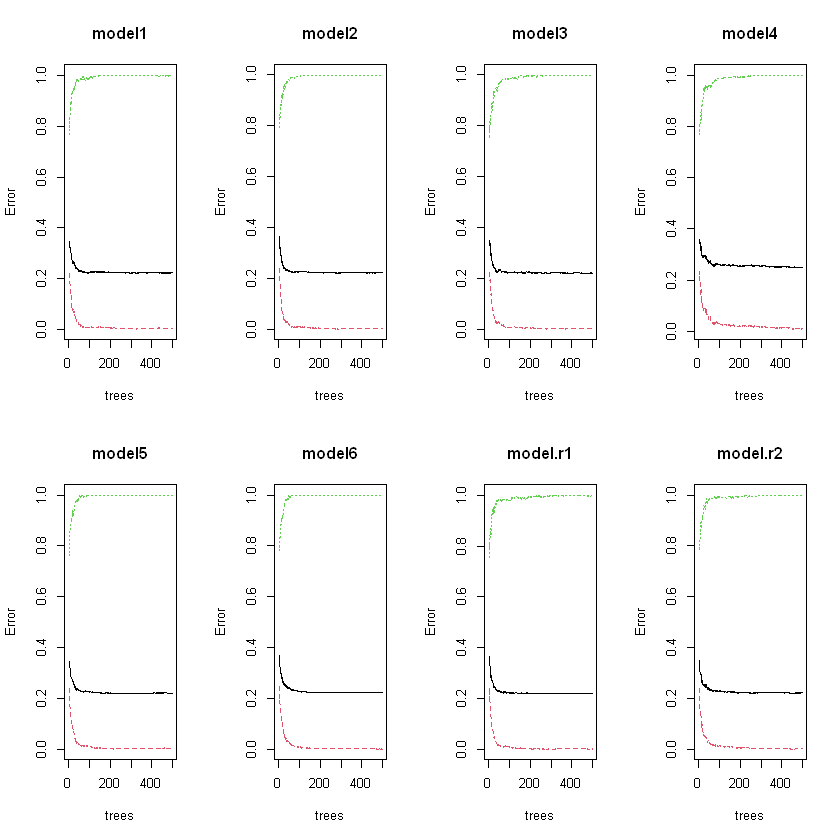

In [34]:
par(mfrow = c(2,4))
plot(model1)
plot(model2)
plot(model3)
plot(model4)
plot(model5)
plot(model6)
plot(model.r1)
plot(model.r2)

# 3.1. Visualization for False Positive Value

## 3.1.1. Functions for Random Forest

In [35]:
model.to.pred <-function(model, trainset, Y){
    pred1=predict(model,type = "prob")

    perf = prediction(pred1[,2], trainset$Y)
    pred = performance(perf, "tpr","fpr")

    return(pred)
}

# for all (rf/ glm)
pred.to.df <-function(pred){
    #str(pred)
    df.pred <- data.frame(fpr=pred@x.values,tpr=pred@y.values)
    colnames(df.pred)<-c('fpr','tpr')
    
    return(df.pred)
    }

# auc
model.to.auc <-function(model, trainset, Y){
    pred1=predict(model,type = "prob")

    perf = prediction(pred1[,2], trainset$Y)
    pred = performance(perf, "auc")
    
    df.auc <-data.frame(auc =pred@y.values)
    colnames(df.auc) <-c('auc')

    return(df.auc[[1]])
}

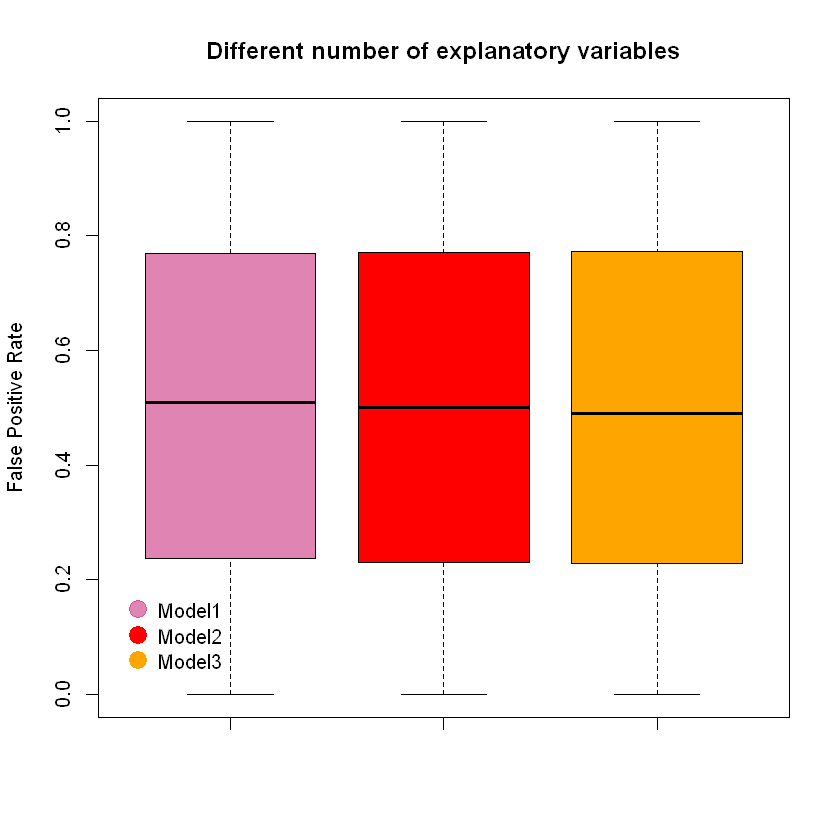

In [36]:
#rf: fpr
rf.pred1<- model.to.pred(model1,trainset,Y)
df.rf.pred1 <- pred.to.df(rf.pred1)

rf.pred2<- model.to.pred(model2,trainset2,Y)
df.rf.pred2 <- pred.to.df(rf.pred2)

rf.pred3<- model.to.pred(model3,trainset3,Y)
df.rf.pred3 <- pred.to.df(rf.pred3)

myColors <- c( rgb(0.8,0.2,0.5,0.6), "red", 'orange')
boxplot(df.rf.pred1[,1],df.rf.pred2[,1], df.rf.pred3[,1], col = myColors, main = 'Different number of explanatory variables', ylab='False Positive Rate')
legend("bottomleft", legend = c("Model1","Model2", "Model3") , 
    col = c(rgb(0.8,0.2,0.5,0.6), "red", "orange") , bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

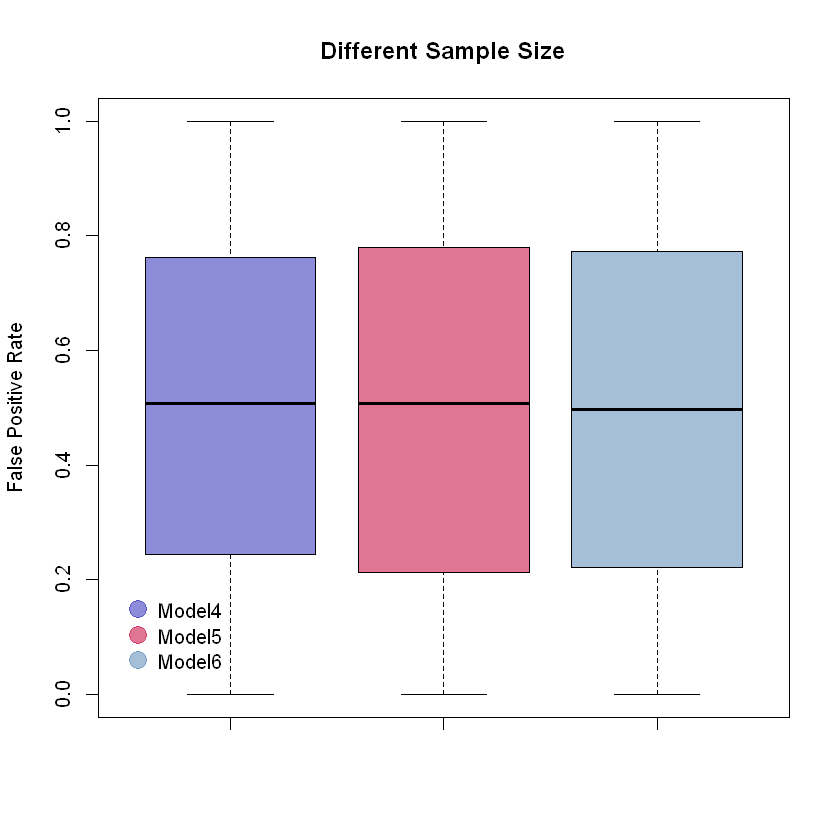

In [37]:
#rf : fpr

rf.pred4<- model.to.pred(model4,trainset.s,Y)
df.rf.pred4 <- pred.to.df(rf.pred4)

rf.pred5<- model.to.pred(model5,trainset.m,Y)
df.rf.pred5 <- pred.to.df(rf.pred5)

rf.pred6<- model.to.pred(model6,trainset.l,Y)
df.rf.pred6 <- pred.to.df(rf.pred6)


myColors <- c(rgb(0.1,0.1,0.7,0.5), rgb(0.8,0.1,0.3,0.6), rgb(0.3,0.5,0.7,0.5))
boxplot(df.rf.pred4[,1],df.rf.pred5[,1], df.rf.pred6[,1], col = myColors, main = 'Different Sample Size', ylab='False Positive Rate')
legend("bottomleft", legend = c("Model4","Model5","Model6") , 
    col = c(rgb(0.1,0.1,0.7,0.5) , rgb(0.8,0.1,0.3,0.6), rgb(0.3,0.5,0.7,0.5)) , bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

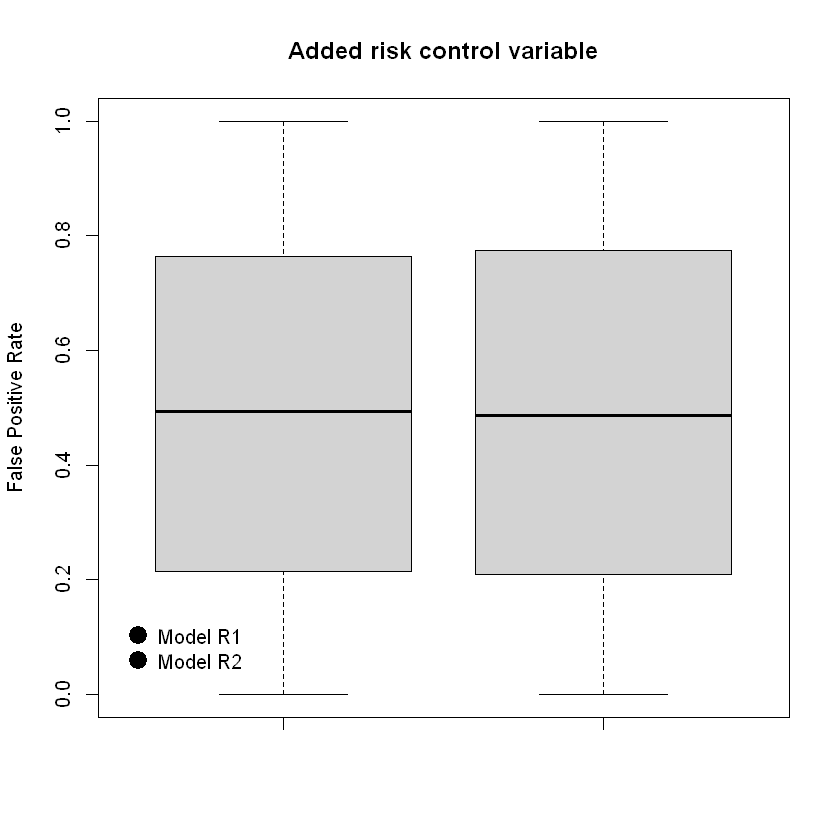

In [38]:
#rf: fpr
rf.pred.r1<- model.to.pred(model.r1,trainset.r1,Y)
df.rf.pred.r1 <- pred.to.df(rf.pred.r1)

rf.pred.r2<- model.to.pred(model.r2,trainset.r2,Y)
df.rf.pred.r2 <- pred.to.df(rf.pred.r2)

boxplot(df.rf.pred.r1[,1],df.rf.pred.r2[,1], main = 'Added risk control variable', ylab='False Positive Rate')
legend("bottomleft", legend = c("Model R1","Model R2") , bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

## 3.1.2. Fuctions for Logistic Regression Models

In [39]:
#model to pred (for fpr and tpr / ROC)
lm.to.pred<-function(logit.model, trainset, Y){
    logit.pred1=predict(logit.model, type = "response")

    logit.perf = prediction(logit.pred1, factor(trainset$Y))
    logit.pred = performance(logit.perf, "tpr", "fpr")
    
    return(logit.pred)
    }


#auc
lm.to.auc <-function(logit.model, trainset, Y){
    logit.pred1=predict(logit.model, type = "response")

    logit.perf = prediction(logit.pred1, trainset$Y)
    logit.pred = performance(logit.perf, "auc")

    df.auc <-data.frame(auc =logit.pred@y.values)
    colnames(df.auc) <-c('auc')
    df.auc

    return(df.auc[[1]])
}

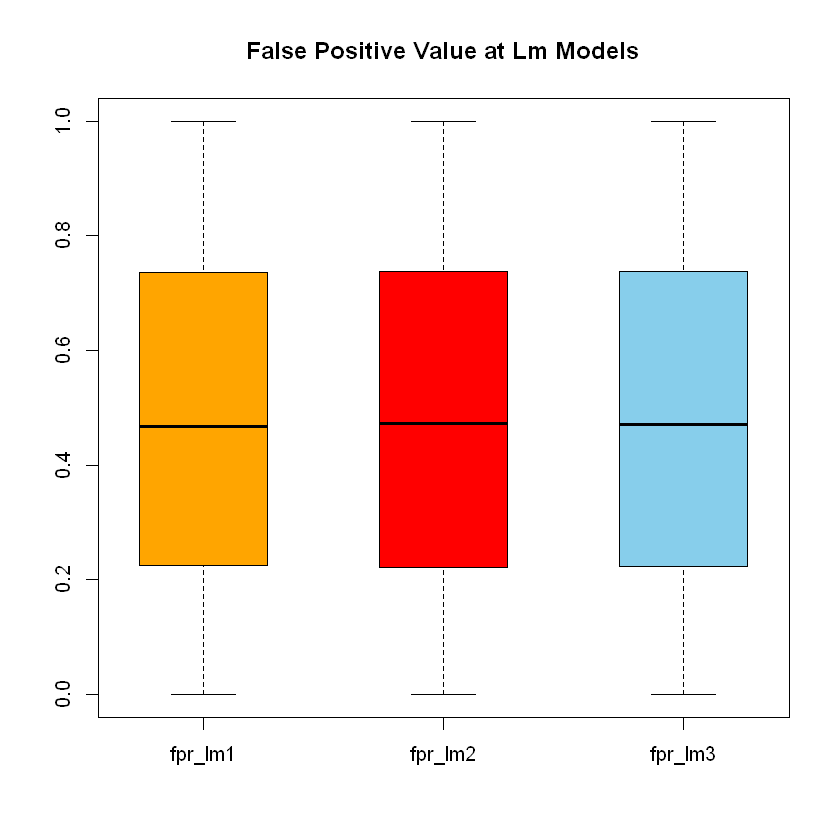

In [40]:
#fpr
lm.pred1 <- lm.to.pred(lm1, trainset, Y)
lm.pred2 <- lm.to.pred(lm2, trainset2, Y)
lm.pred3 <- lm.to.pred(lm3, trainset3, Y)
lm.pred4 <- lm.to.pred(lm4, trainset.s, Y)
lm.pred5 <- lm.to.pred(lm5, trainset.m, Y)
lm.pred6 <- lm.to.pred(lm6, trainset.l, Y)

lm.pred.r1 <- lm.to.pred(lm.r1, trainset.r1, Y)
lm.pred.r2 <- lm.to.pred(lm.r2, trainset.r2, Y)

df.lm.pred1 <- pred.to.df(lm.pred1)
df.lm.pred2 <- pred.to.df(lm.pred2)
df.lm.pred3 <- pred.to.df(lm.pred3)
df.lm.pred4 <- pred.to.df(lm.pred4)
df.lm.pred5 <- pred.to.df(lm.pred5)
df.lm.pred6 <- pred.to.df(lm.pred6)

df.lm.pred.r1 <- pred.to.df(lm.pred.r1)
df.lm.pred.r2 <- pred.to.df(lm.pred.r2)

# box plot
df.lm.bp = data.frame(fpr_lm1 = df.lm.pred1[,1],fpr_lm2 = df.lm.pred2[,1], fpr_lm3 = df.lm.pred3[,1])#,df.lm.pred4,df.lm.pred5,df.lm.pred6)

boxplot(df.lm.bp, at = 1:3 + c(1.5, 2, 2.5), col = c('orange','red','skyblue'), main ="False Positive Value at Lm Models")

### 3.2.3. Comparison Between Models

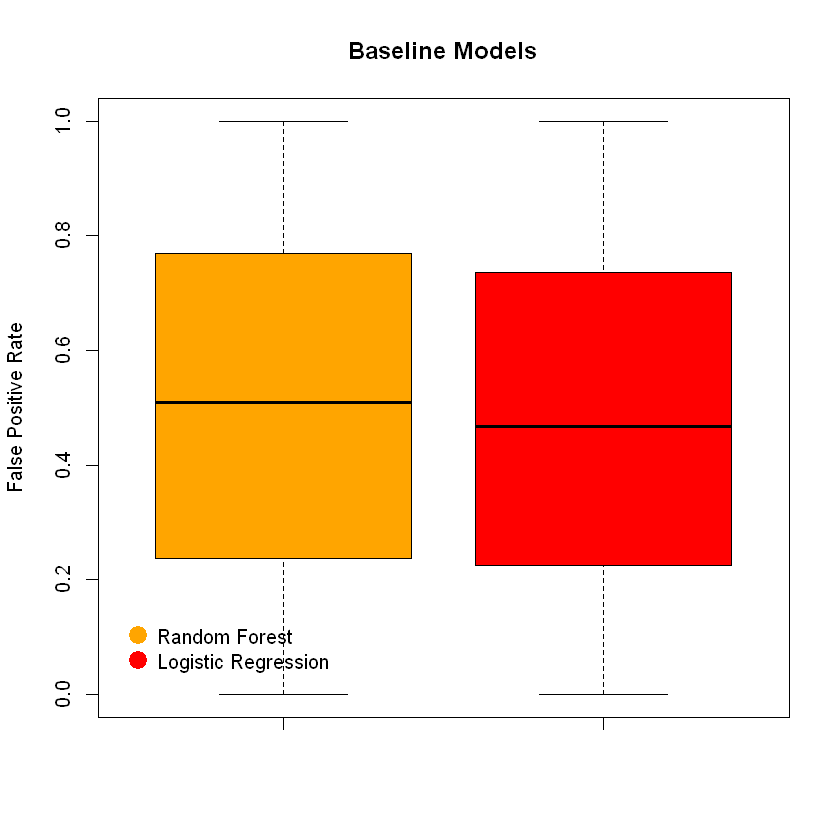

In [41]:
#baseline model for each method
# Give the chart file a name.
#png(file = "../figure/baseline_comparison_fpr.png")

boxplot(df.rf.pred1[,1], df.lm.pred1[,1], col = c('orange','red'), main ="Baseline Models",ylab = 'False Positive Rate')
legend("bottomleft", legend = c("Random Forest","Logistic Regression"), col = c('orange','red'), bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

# save
#dev.off()

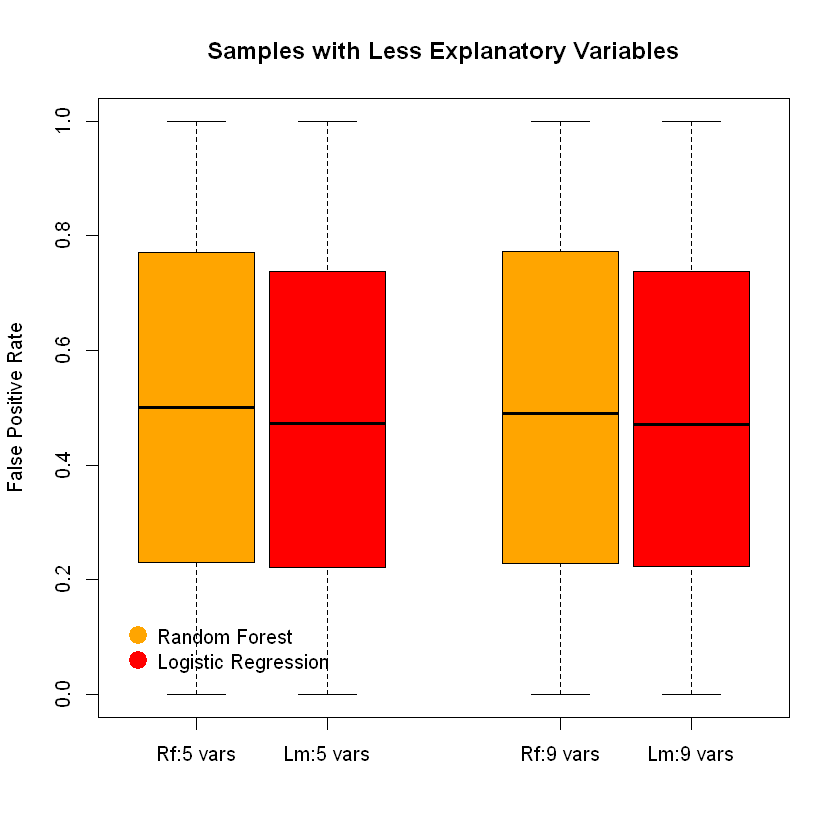

In [42]:
# dropped explanatory samples: model2 and 3
# Give the chart file a name.
#png(file = "../figure/explanatory_comparison_fpr.png")

boxplot(df.rf.pred2[,1], df.lm.pred2[,1], df.rf.pred3[,1], df.lm.pred3[,1], at= 1:4 + c(1,0.9,1.5,1.4),col = c('orange','red','orange','red'), names=c('Rf:5 vars','Lm:5 vars','Rf:9 vars','Lm:9 vars'), main ="Samples with Less Explanatory Variables", ylab = 'False Positive Rate')
legend("bottomleft", legend = c("Random Forest","Logistic Regression"), col = c('orange','red'), bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

# save
#dev.off()

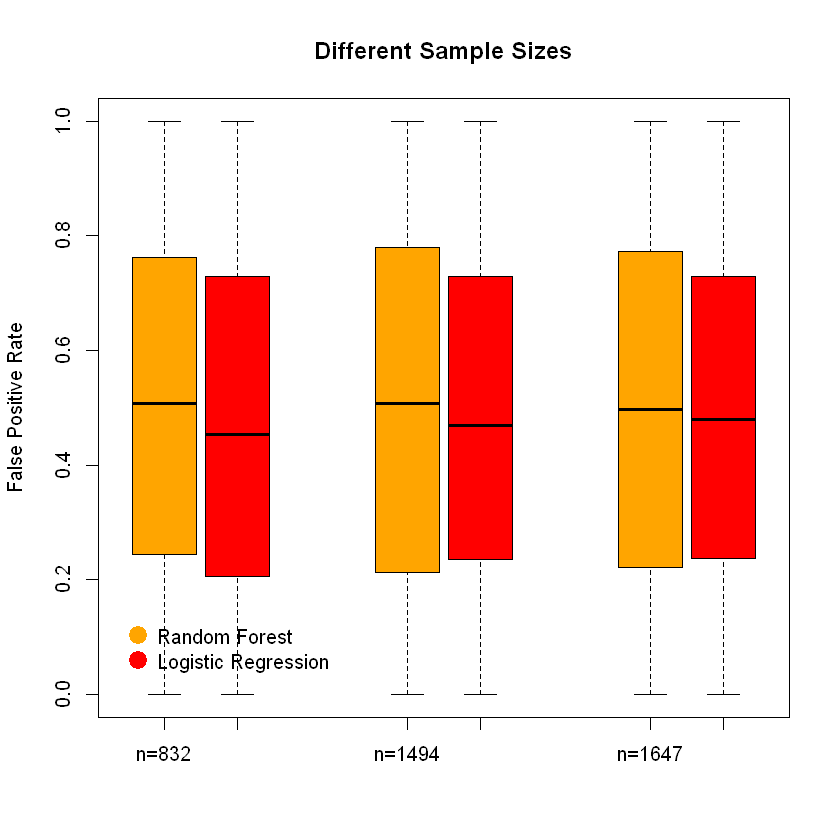

In [44]:
# different sample size: model4 to 6
# Give the chart file a name.
#png(file = "../figure/samplesize_comparison_fpr.png")

boxplot(df.rf.pred4[,1], df.lm.pred4[,1], df.rf.pred5[,1], df.lm.pred5[,1],df.rf.pred6[,1], df.lm.pred6[,1], at= 1:6 + c(1,0.9, 2,1.9,3,2.9),col = c('orange','red','orange','red','orange','red'), names=c('n=832','000000','n=1494','000000','n=1647','000000'), main ="Different Sample Sizes", ylab = 'False Positive Rate')
legend("bottomleft", legend = c("Random Forest","Logistic Regression"), col = c('orange','red'), bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

# save
#dev.off()

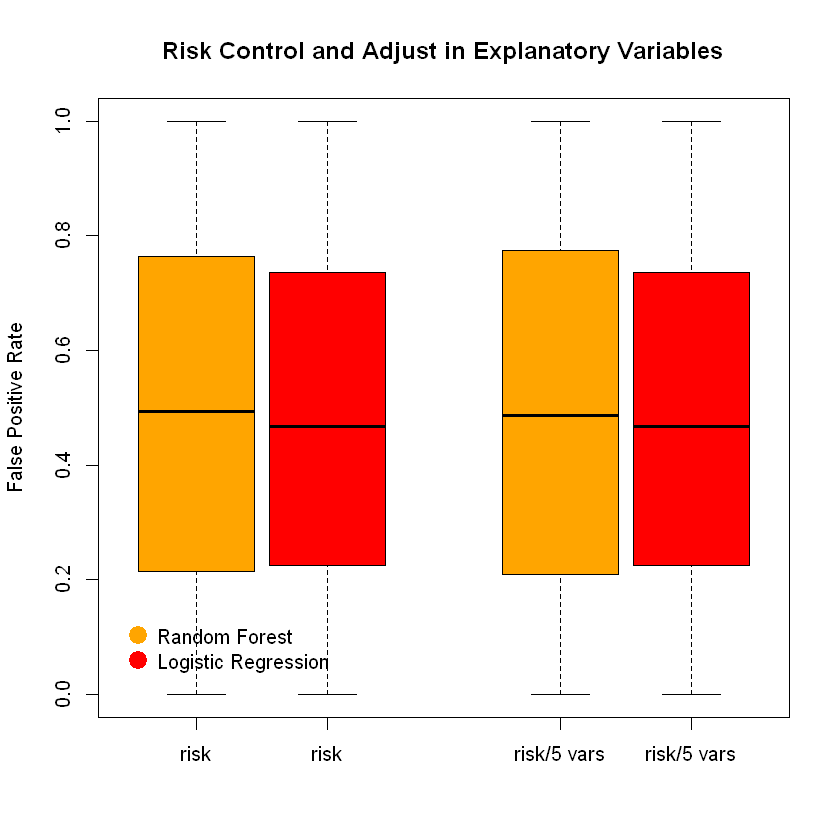

In [45]:
# added risk ctrl and dropped explanatory
# Give the chart file a name.
#png(file = "../figure/riskgrp_comparison_fpr.png")

boxplot(df.rf.pred.r1[,1], df.lm.pred.r1[,1], df.rf.pred.r2[,1], df.lm.pred.r2[,1], at= 1:4 + c(1,0.9,1.5,1.4),col = c('orange','red','orange','red'), names=c('risk','risk','risk/5 vars','risk/5 vars'), main ="Risk Control and Adjust in Explanatory Variables", ylab = 'False Positive Rate')
legend("bottomleft", legend = c("Random Forest","Logistic Regression"), col = c('orange','red'), bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

#save
#dev.off()

## 3.3 TPR

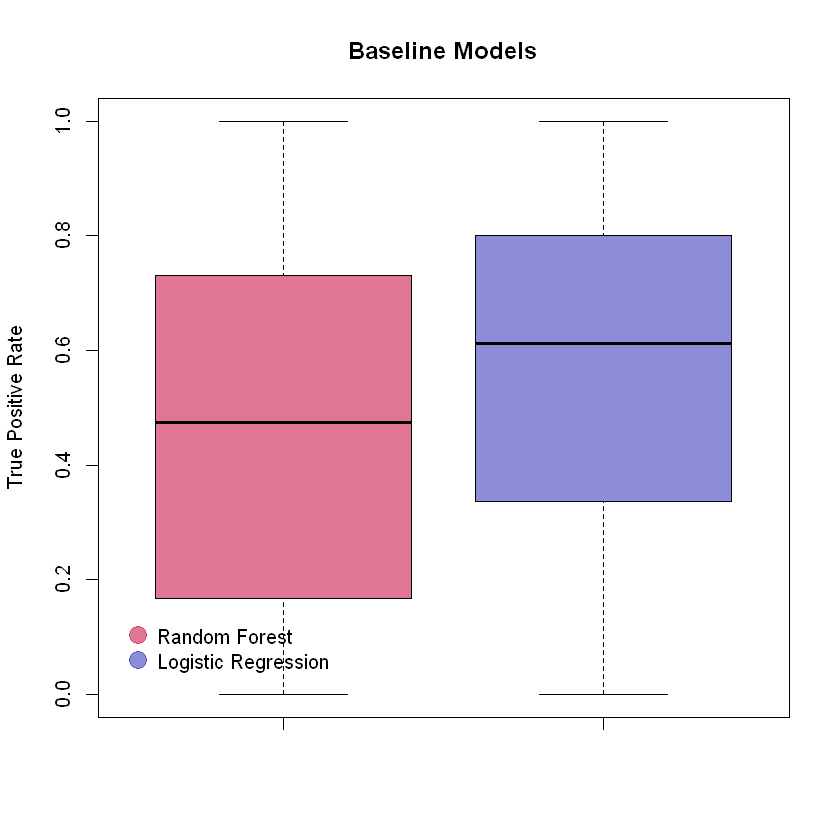

In [46]:
#TPR: baseline model for each method
#Give the chart file a name.
#png(file = "../figure/baseline_comparison_tpr.png")

boxplot(df.rf.pred1[,2], df.lm.pred1[,2], col = c( rgb(0.8,0.1,0.3,0.6),rgb(0.1,0.1,0.7,0.5)), main ="Baseline Models",ylab = 'True Positive Rate')
legend("bottomleft", legend = c("Random Forest","Logistic Regression"), col = c( rgb(0.8,0.1,0.3,0.6),rgb(0.1,0.1,0.7,0.5)), bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

# save
#dev.off()

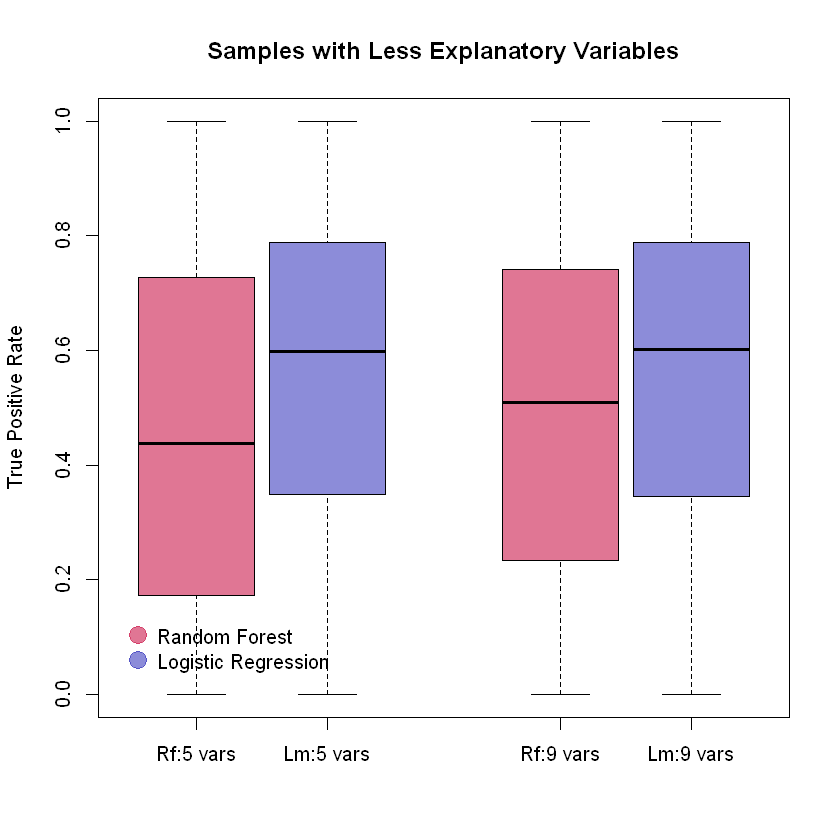

In [47]:
rfc = rgb(0.8,0.1,0.3,0.6)
lmc = rgb(0.1,0.1,0.7,0.5)
# tpr: dropped explanatory samples: model2 and 3
# Give the chart file a name.
#png(file = "../figure/explanatory_comparison_tpr.png")

boxplot(df.rf.pred2[,2], df.lm.pred2[,2], df.rf.pred3[,2], df.lm.pred3[,2], at= 1:4 + c(1,0.9,1.5,1.4),col = c( rgb(0.8,0.1,0.3,0.6),rgb(0.1,0.1,0.7,0.5), rgb(0.8,0.1,0.3,0.6),rgb(0.1,0.1,0.7,0.5)), names=c('Rf:5 vars','Lm:5 vars','Rf:9 vars','Lm:9 vars'), main ="Samples with Less Explanatory Variables", ylab = 'True Positive Rate')
legend("bottomleft", legend = c("Random Forest","Logistic Regression"), col = c( rgb(0.8,0.1,0.3,0.6),rgb(0.1,0.1,0.7,0.5)), bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

# save
#dev.off()

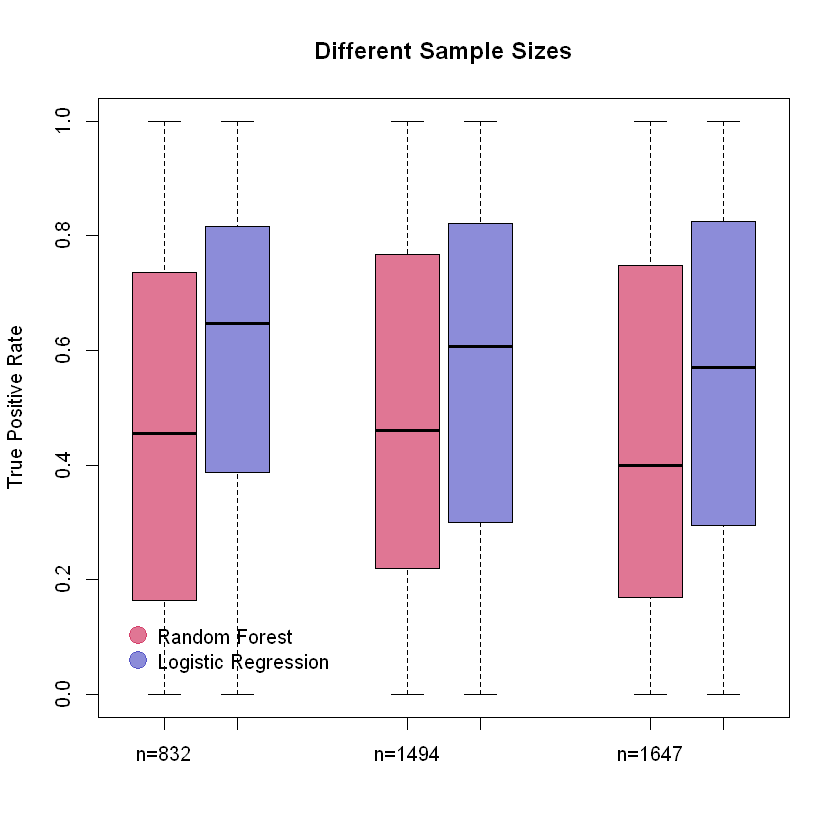

In [48]:
# tpr: different sample size: model4 to 6
# Give the chart file a name.
#png(file = "../figure/samplesize_comparison_tpr.png")

boxplot(df.rf.pred4[,2], df.lm.pred4[,2], df.rf.pred5[,2], df.lm.pred5[,2],df.rf.pred6[,2], df.lm.pred6[,2], at= 1:6 + c(1,0.9, 2,1.9,3,2.9),col = c(rfc,lmc,rfc,lmc), names=c('n=832','000000','n=1494','000000','n=1647','000000'), main ="Different Sample Sizes", ylab = 'True Positive Rate')
legend("bottomleft", legend = c("Random Forest","Logistic Regression"), col = c(rfc,lmc), bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

# save
#dev.off()

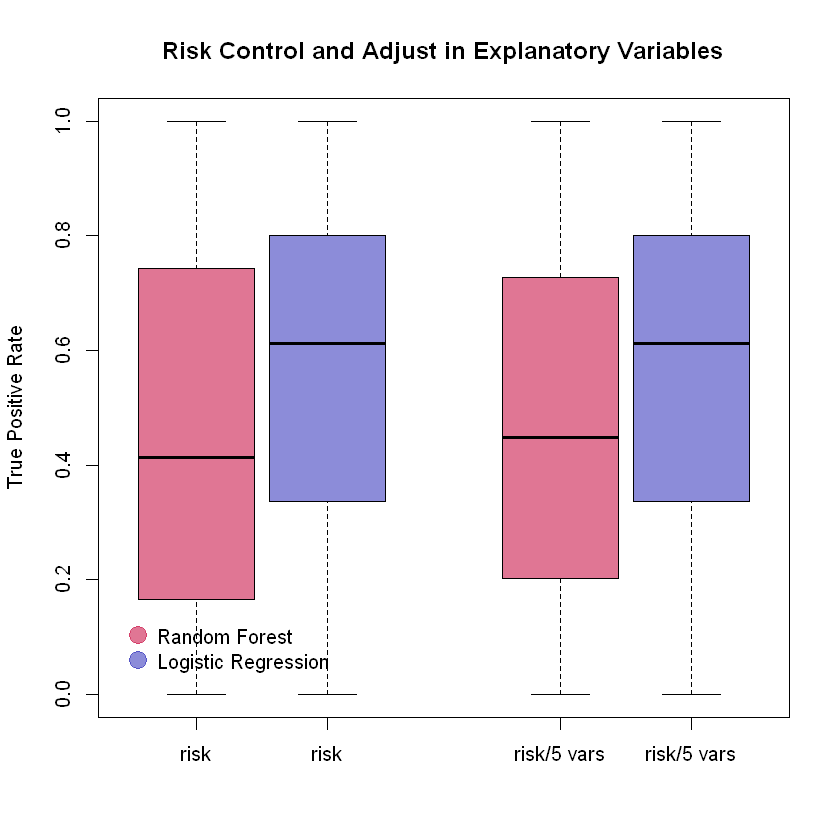

In [49]:
# tpr: added risk ctrl and dropped explanatory
# Give the chart file a name.
#png(file = "../figure/riskgrp_comparison_tpr.png")

boxplot(df.rf.pred.r1[,2], df.lm.pred.r1[,2], df.rf.pred.r2[,2], df.lm.pred.r2[,2], at= 1:4 + c(1,0.9,1.5,1.4),col = c(rfc,lmc,rfc,lmc), names=c('risk','risk','risk/5 vars','risk/5 vars'), main ="Risk Control and Adjust in Explanatory Variables", ylab = 'True Positive Rate')
legend("bottomleft", legend = c("Random Forest","Logistic Regression"), col = c(rfc,lmc), bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.03, 0.05))

#save
#dev.off()

## 3.4 ROC

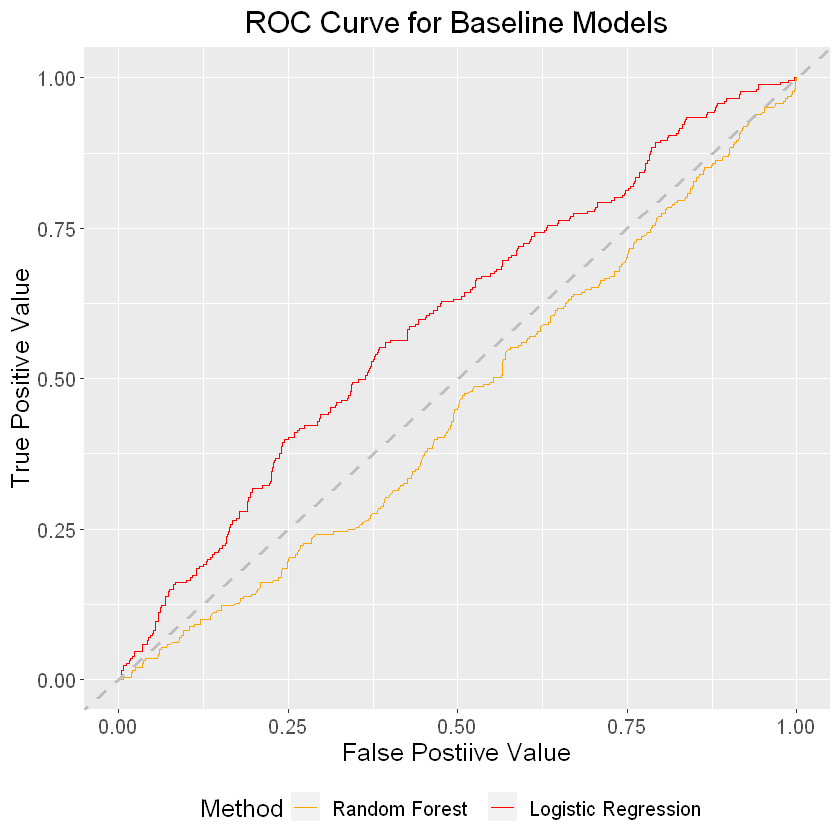

In [50]:
#png(file = "../figure/ROC1.baseline.png")

ggplot() + 
geom_line(data=df.rf.pred1, aes(x=fpr, y=tpr, color="Random Forest")) + 
geom_line(data=df.lm.pred1, aes(x=fpr, y=tpr, color="Logistic Regression")) +
scale_colour_manual(name = "Method",values =  c("Random Forest" = "orange","Logistic Regression" = "red")) +
geom_abline(lwd=1,lty=2,col="gray") +
xlab("False Postiive Value") + 
ylab('True Positive Value') +
ggtitle("ROC Curve for Baseline Models") +
theme(text = element_text(size=15), plot.title =element_text(hjust = 0.5), legend.position="bottom")

#dev.off()

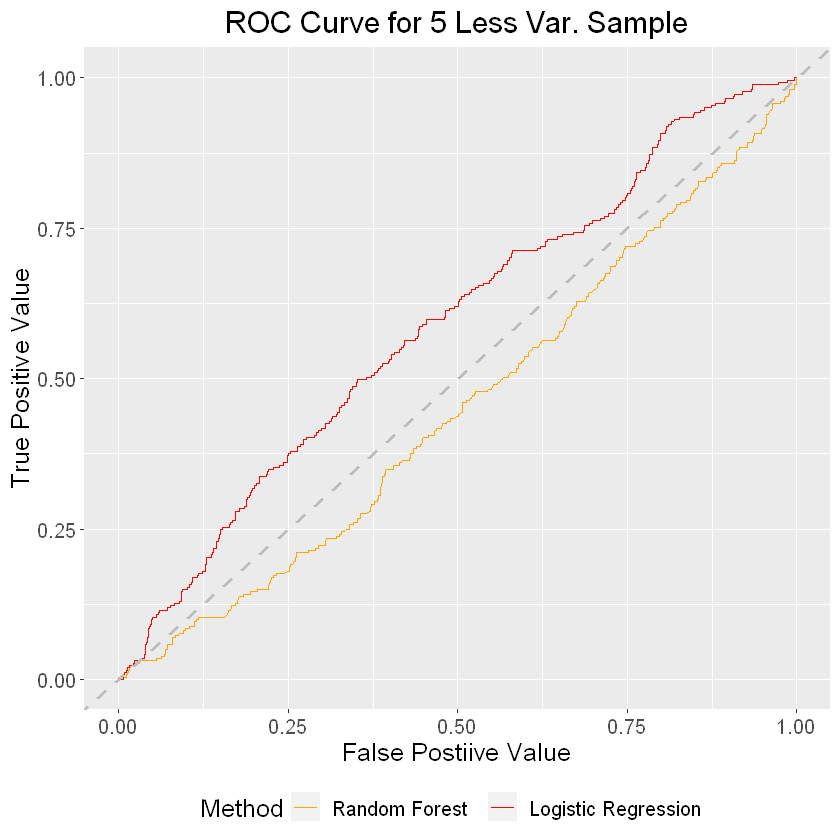

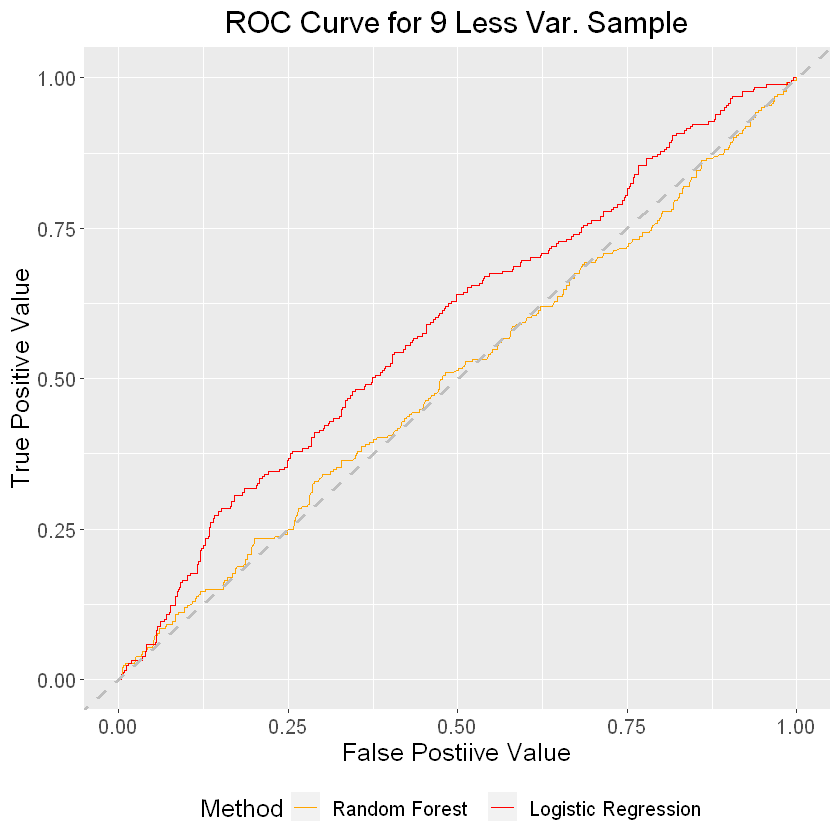

In [51]:

#attach(mtcars)
#par(mfrow=c(1,2))

#png(file = "../figure/ROC2.explanatory1.png")

ggplot() + 
geom_line(data=df.rf.pred2, aes(x=fpr, y=tpr, color="Random Forest")) + 
geom_line(data=df.lm.pred2, aes(x=fpr, y=tpr, color="Logistic Regression")) +
scale_colour_manual(name = "Method",values =  c("Random Forest" = "orange","Logistic Regression" = "red")) +
geom_abline(lwd=1,lty=2,col="gray") +
xlab("False Postiive Value") + 
ylab('True Positive Value') +
ggtitle("ROC Curve for 5 Less Var. Sample") +
theme(text = element_text(size=15), plot.title =element_text(hjust = 0.5),legend.position = 'bottom')
#dev.off()


####
#png(file = "../figure/ROC2.explanatory2.png")

ggplot() + 
geom_line(data=df.rf.pred3, aes(x=fpr, y=tpr, color="Random Forest")) + 
geom_line(data=df.lm.pred3, aes(x=fpr, y=tpr, color="Logistic Regression")) +
scale_colour_manual(name = "Method",values =  c("Random Forest" = "orange","Logistic Regression" = "red")) +
geom_abline(lwd=1,lty=2,col="gray") +
xlab("False Postiive Value") + 
ylab('True Positive Value') +
ggtitle("ROC Curve for 9 Less Var. Sample") +
theme(text = element_text(size=15), plot.title =element_text(hjust = 0.5),legend.position = 'bottom')
#dev.off()

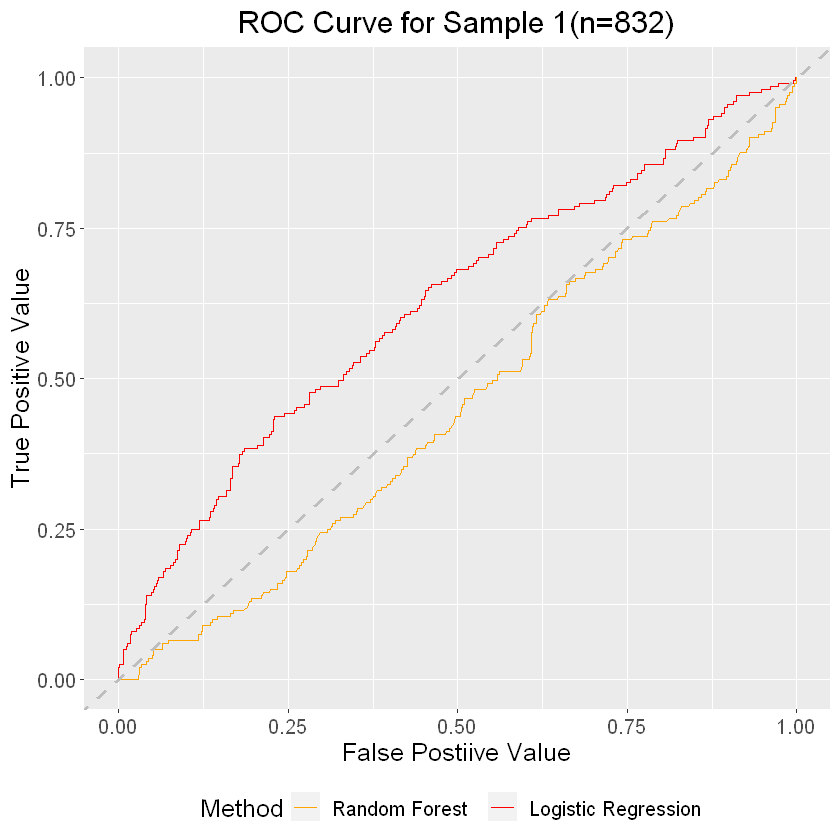

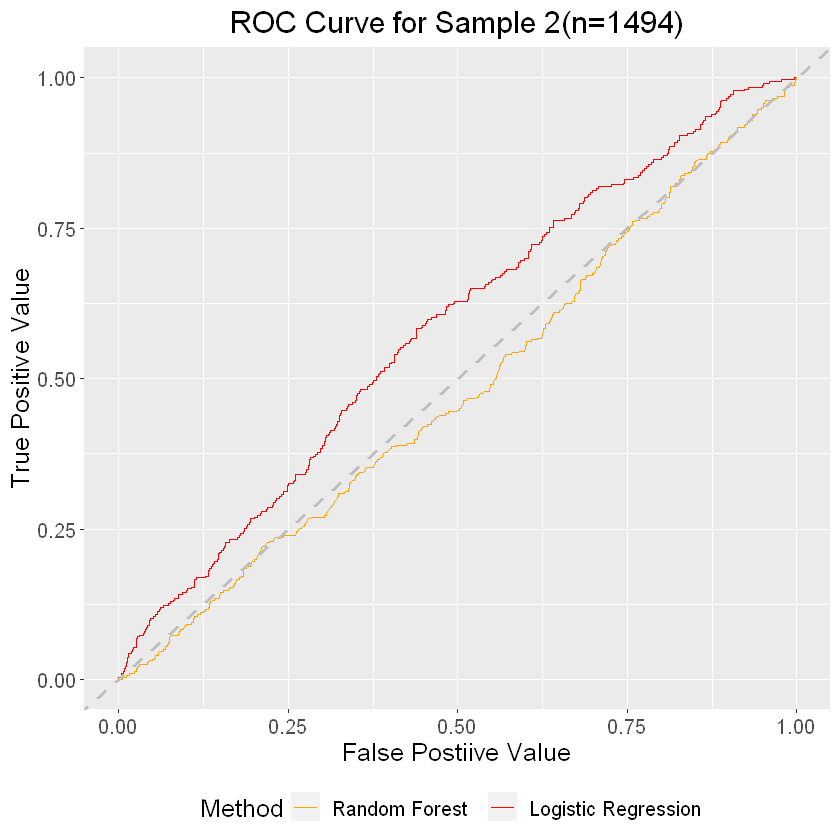

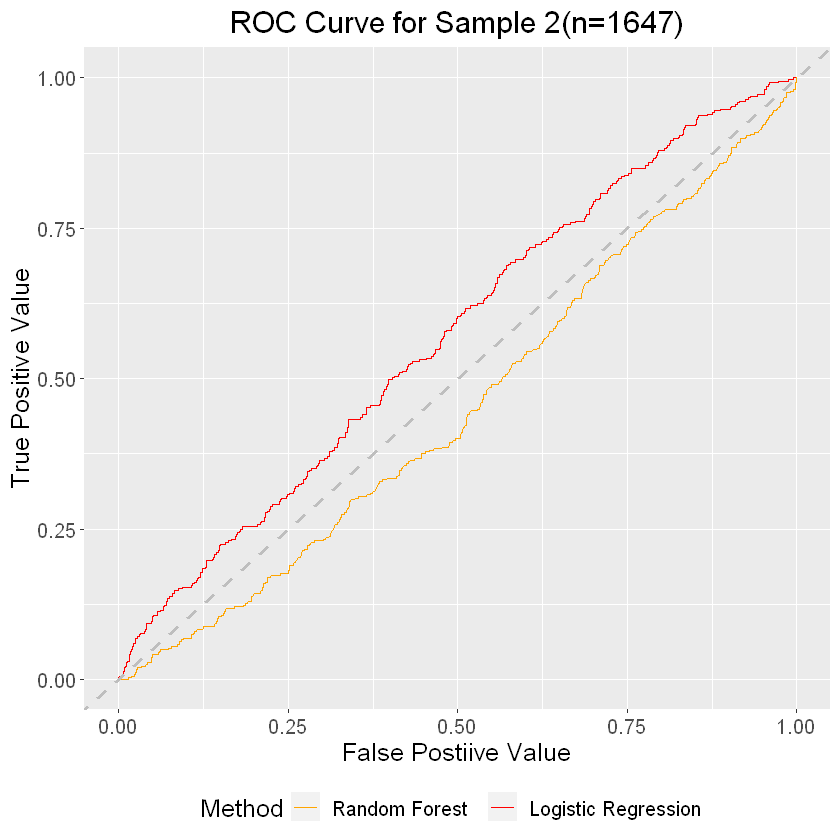

In [52]:
#attach(mtcars)
#png(file = "../figure/ROC3.samplesize1.png")

ggplot() + 
geom_line(data=df.rf.pred4, aes(x=fpr, y=tpr, color="Random Forest")) + 
geom_line(data=df.lm.pred4, aes(x=fpr, y=tpr, color="Logistic Regression")) +
scale_colour_manual(name = "Method",values =  c("Random Forest" = "orange","Logistic Regression" = "red")) +
geom_abline(lwd=1,lty=2,col="gray") +
xlab("False Postiive Value") + 
ylab('True Positive Value') +
ggtitle("ROC Curve for Sample 1(n=832)") +
theme(text = element_text(size=15), plot.title =element_text(hjust = 0.5),legend.position = 'bottom')

#dev.off()


####
#png(file = "../figure/ROC3.samplesize2.png")
ggplot() + 
geom_line(data=df.rf.pred5, aes(x=fpr, y=tpr, color="Random Forest")) + 
geom_line(data=df.lm.pred5, aes(x=fpr, y=tpr, color="Logistic Regression")) +
scale_colour_manual(name = "Method",values =  c("Random Forest" = "orange","Logistic Regression" = "red")) +
geom_abline(lwd=1,lty=2,col="gray") +
xlab("False Postiive Value") + 
ylab('True Positive Value') +
ggtitle("ROC Curve for Sample 2(n=1494)") +
theme(text = element_text(size=15), plot.title =element_text(hjust = 0.5),legend.position = 'bottom')
#dev.off()


#png(file = "../figure/ROC3.samplesize3.png")
ggplot() + 
geom_line(data=df.rf.pred6, aes(x=fpr, y=tpr, color="Random Forest")) + 
geom_line(data=df.lm.pred6, aes(x=fpr, y=tpr, color="Logistic Regression")) +
scale_colour_manual(name = "Method",values =  c("Random Forest" = "orange","Logistic Regression" = "red")) +
geom_abline(lwd=1,lty=2,col="gray") +
xlab("False Postiive Value") + 
ylab('True Positive Value') +
ggtitle("ROC Curve for Sample 2(n=1647)") +
theme(text = element_text(size=15), plot.title =element_text(hjust = 0.5),legend.position = 'bottom')
#dev.off()

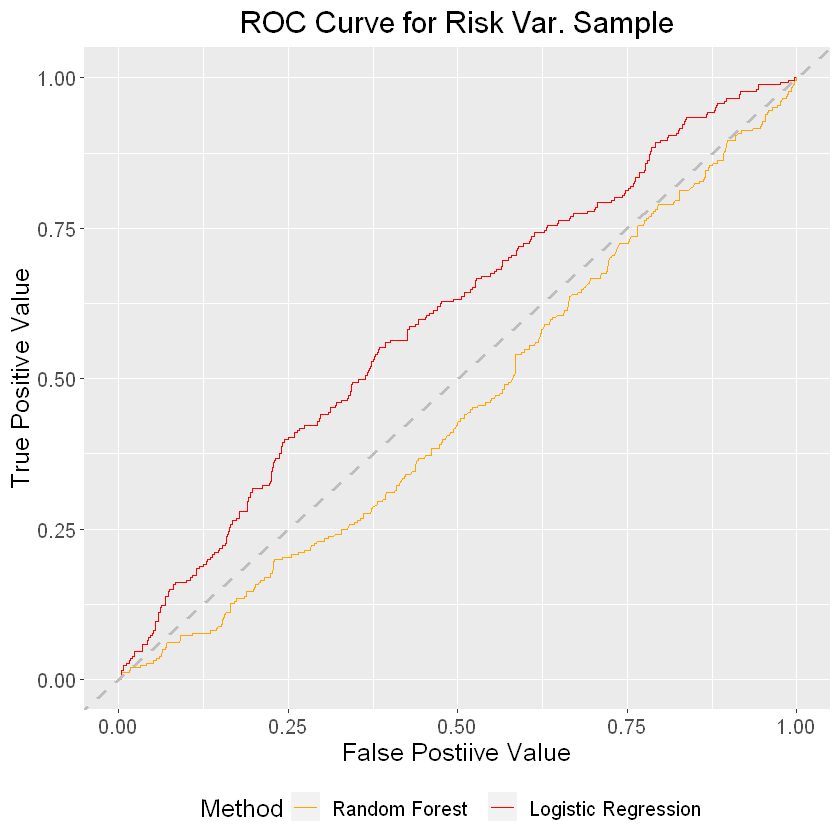

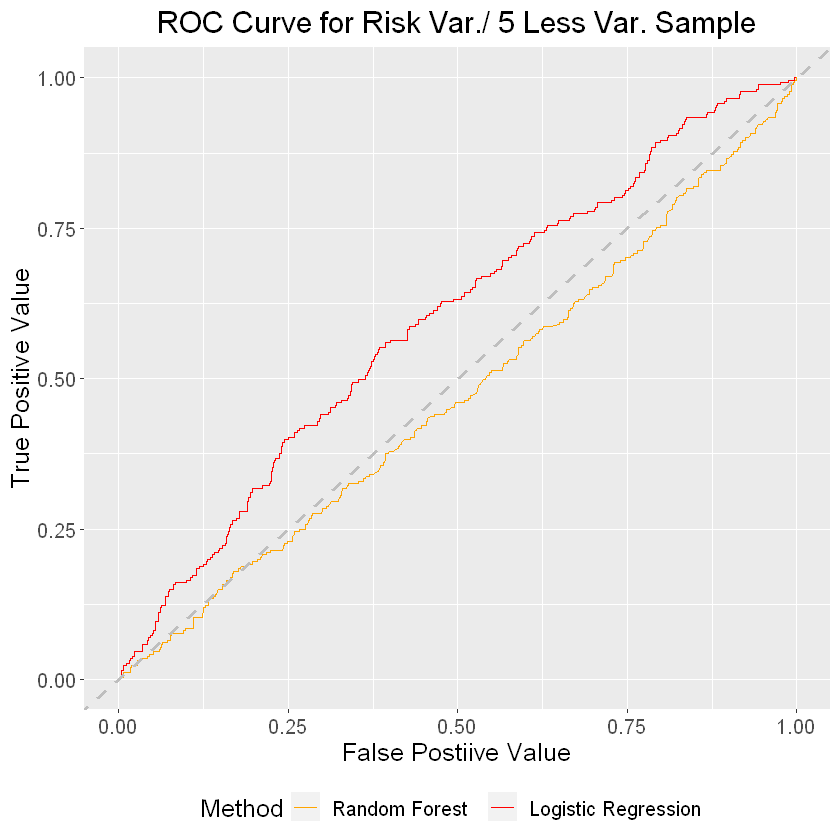

In [53]:
#png(file = "../figure/ROC4.risk1.png")

ggplot() + 
geom_line(data=df.rf.pred.r1, aes(x=fpr, y=tpr, color="Random Forest")) + 
geom_line(data=df.lm.pred.r1, aes(x=fpr, y=tpr, color="Logistic Regression")) +
scale_colour_manual(name = "Method",values =  c("Random Forest" = "orange","Logistic Regression" = "red")) +
geom_abline(lwd=1,lty=2,col="gray") +
xlab("False Postiive Value") + 
ylab('True Positive Value') +
ggtitle("ROC Curve for Risk Var. Sample") +
theme(text = element_text(size=15), plot.title =element_text(hjust = 0.5),legend.position = 'bottom')

#dev.off()


####
#png(file = "../figure/ROC4.risk2.png")
ggplot() + 
geom_line(data=df.rf.pred.r2, aes(x=fpr, y=tpr, color="Random Forest")) + 
geom_line(data=df.lm.pred.r2, aes(x=fpr, y=tpr, color="Logistic Regression")) +
scale_colour_manual(name = "Method",values =  c("Random Forest" = "orange","Logistic Regression" = "red")) +
geom_abline(lwd=1,lty=2,col="gray") +
xlab("False Postiive Value") + 
ylab('True Positive Value') +
ggtitle("ROC Curve for Risk Var./ 5 Less Var. Sample") +
theme(text = element_text(size=15), plot.title =element_text(hjust = 0.5),legend.position = 'bottom')
#dev.off()

## 3.5 AUC

In [54]:
model.to.auc <-function(model, trainset, Y){
    pred1=predict(model,type = "prob")

    perf = prediction(pred1[,2], trainset$Y)
    pred = performance(perf, "auc")
    
    df.auc <-data.frame(auc =pred@y.values)
    colnames(df.auc) <-c('auc')

    return(df.auc[[1]])
}

In [55]:
#auc: Rf
data.frame(auc = c(model.to.auc(model1,trainset,Y),
model.to.auc(model2,trainset2,Y),
model.to.auc(model3,trainset3,Y),
model.to.auc(model4,trainset.s,Y),
model.to.auc(model5,trainset.m,Y),
model.to.auc(model6,trainset.l,Y),
model.to.auc(model.r1,trainset.r1,Y),
model.to.auc(model.r2,trainset.r2,Y)))

auc
<dbl>
0.4562074
0.4521052
0.5024365
0.4532764
0.4819982
0.4529289
0.4539569
0.4723596


In [56]:
#auc: logisitc regression
data.frame(auc = c(lm.to.auc(lm1,trainset,Y),
lm.to.auc(lm2,trainset2,Y),
lm.to.auc(lm3,trainset3,Y),
lm.to.auc(lm4,trainset.s,Y),
lm.to.auc(lm5,trainset.m,Y),
lm.to.auc(lm6,trainset.l,Y),
lm.to.auc(lm.r1,trainset.r1,Y),
lm.to.auc(lm.r2,trainset.r2,Y)))

auc
<dbl>
0.5966265
0.5889017
0.5863805
0.6241219
0.5825306
0.5713568
0.5966265
0.5966265
